In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [ ]:
df = pd.read_csv('train.csv')
df.head(2)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

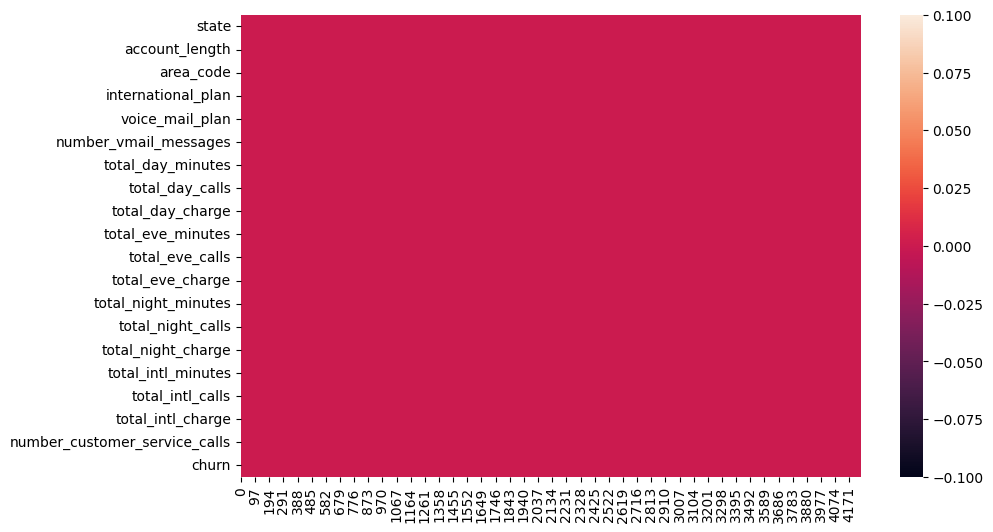

In [ ]:
#nan_values
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose());

In [ ]:
df.describe().style.background_gradient()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [ ]:
# Describe the string data
df.describe(include='O')

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


In [ ]:
a = round(df['churn'].value_counts()/len(df['churn']),2)
churn_ratio=  pd.DataFrame(a).T
churn_ratio = churn_ratio.rename(columns={'no':'Not Churn' , 'yes':'Churn'})
churn_ratio

,Not Churn,Churn
churn,0.86,0.14


In [ ]:
y = df['churn']
print(f'Percentage of Churn:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} customers)')
print(f'Percentage Non_Churn: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} customers)')

Percentage of Churn:  14.07 %  --> (598 customers)
Percentage Non_Churn: 85.93  %  --> (3652 customers)


In [ ]:
print('duplicate values in df' ,df.duplicated().sum() )

duplicate values in df 0


In [ ]:
num_cols =df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 15 numeric columns: account_length, number_vmail_messages, total_day_minutes, total_day_calls, total_day_charge, total_eve_minutes, total_eve_calls, total_eve_charge, total_night_minutes, total_night_calls, total_night_charge, total_intl_minutes, total_intl_calls, total_intl_charge, number_customer_service_calls
And 5 categorical columns: state, area_code, international_plan, voice_mail_plan, churn


In [ ]:
binary_cols = cat_cols[df[cat_cols].nunique() == 2].tolist()
cat_cols = cat_cols.difference(binary_cols).tolist()
display(binary_cols)

['international_plan', 'voice_mail_plan', 'churn']

In [ ]:
colours = ['forestgreen','dodgerblue','goldenrod', 'coral' , 'silver' , 'gold' , 'dodgerblue' , 'forestgreen','dodgerblue','goldenrod', 'coral' , 'silver' , 'gold' ,'limegreen','peru'];

https://matplotlib.org/stable/gallery/color/named_colors.html

In [ ]:
# create fontdicts for formatting figure text
axtitle_dict = {'family': 'serif','color':  'darkred','weight': 'bold','size': 16}
axlab_dict = {'family': 'serif', 'color': 'black','size': 14}

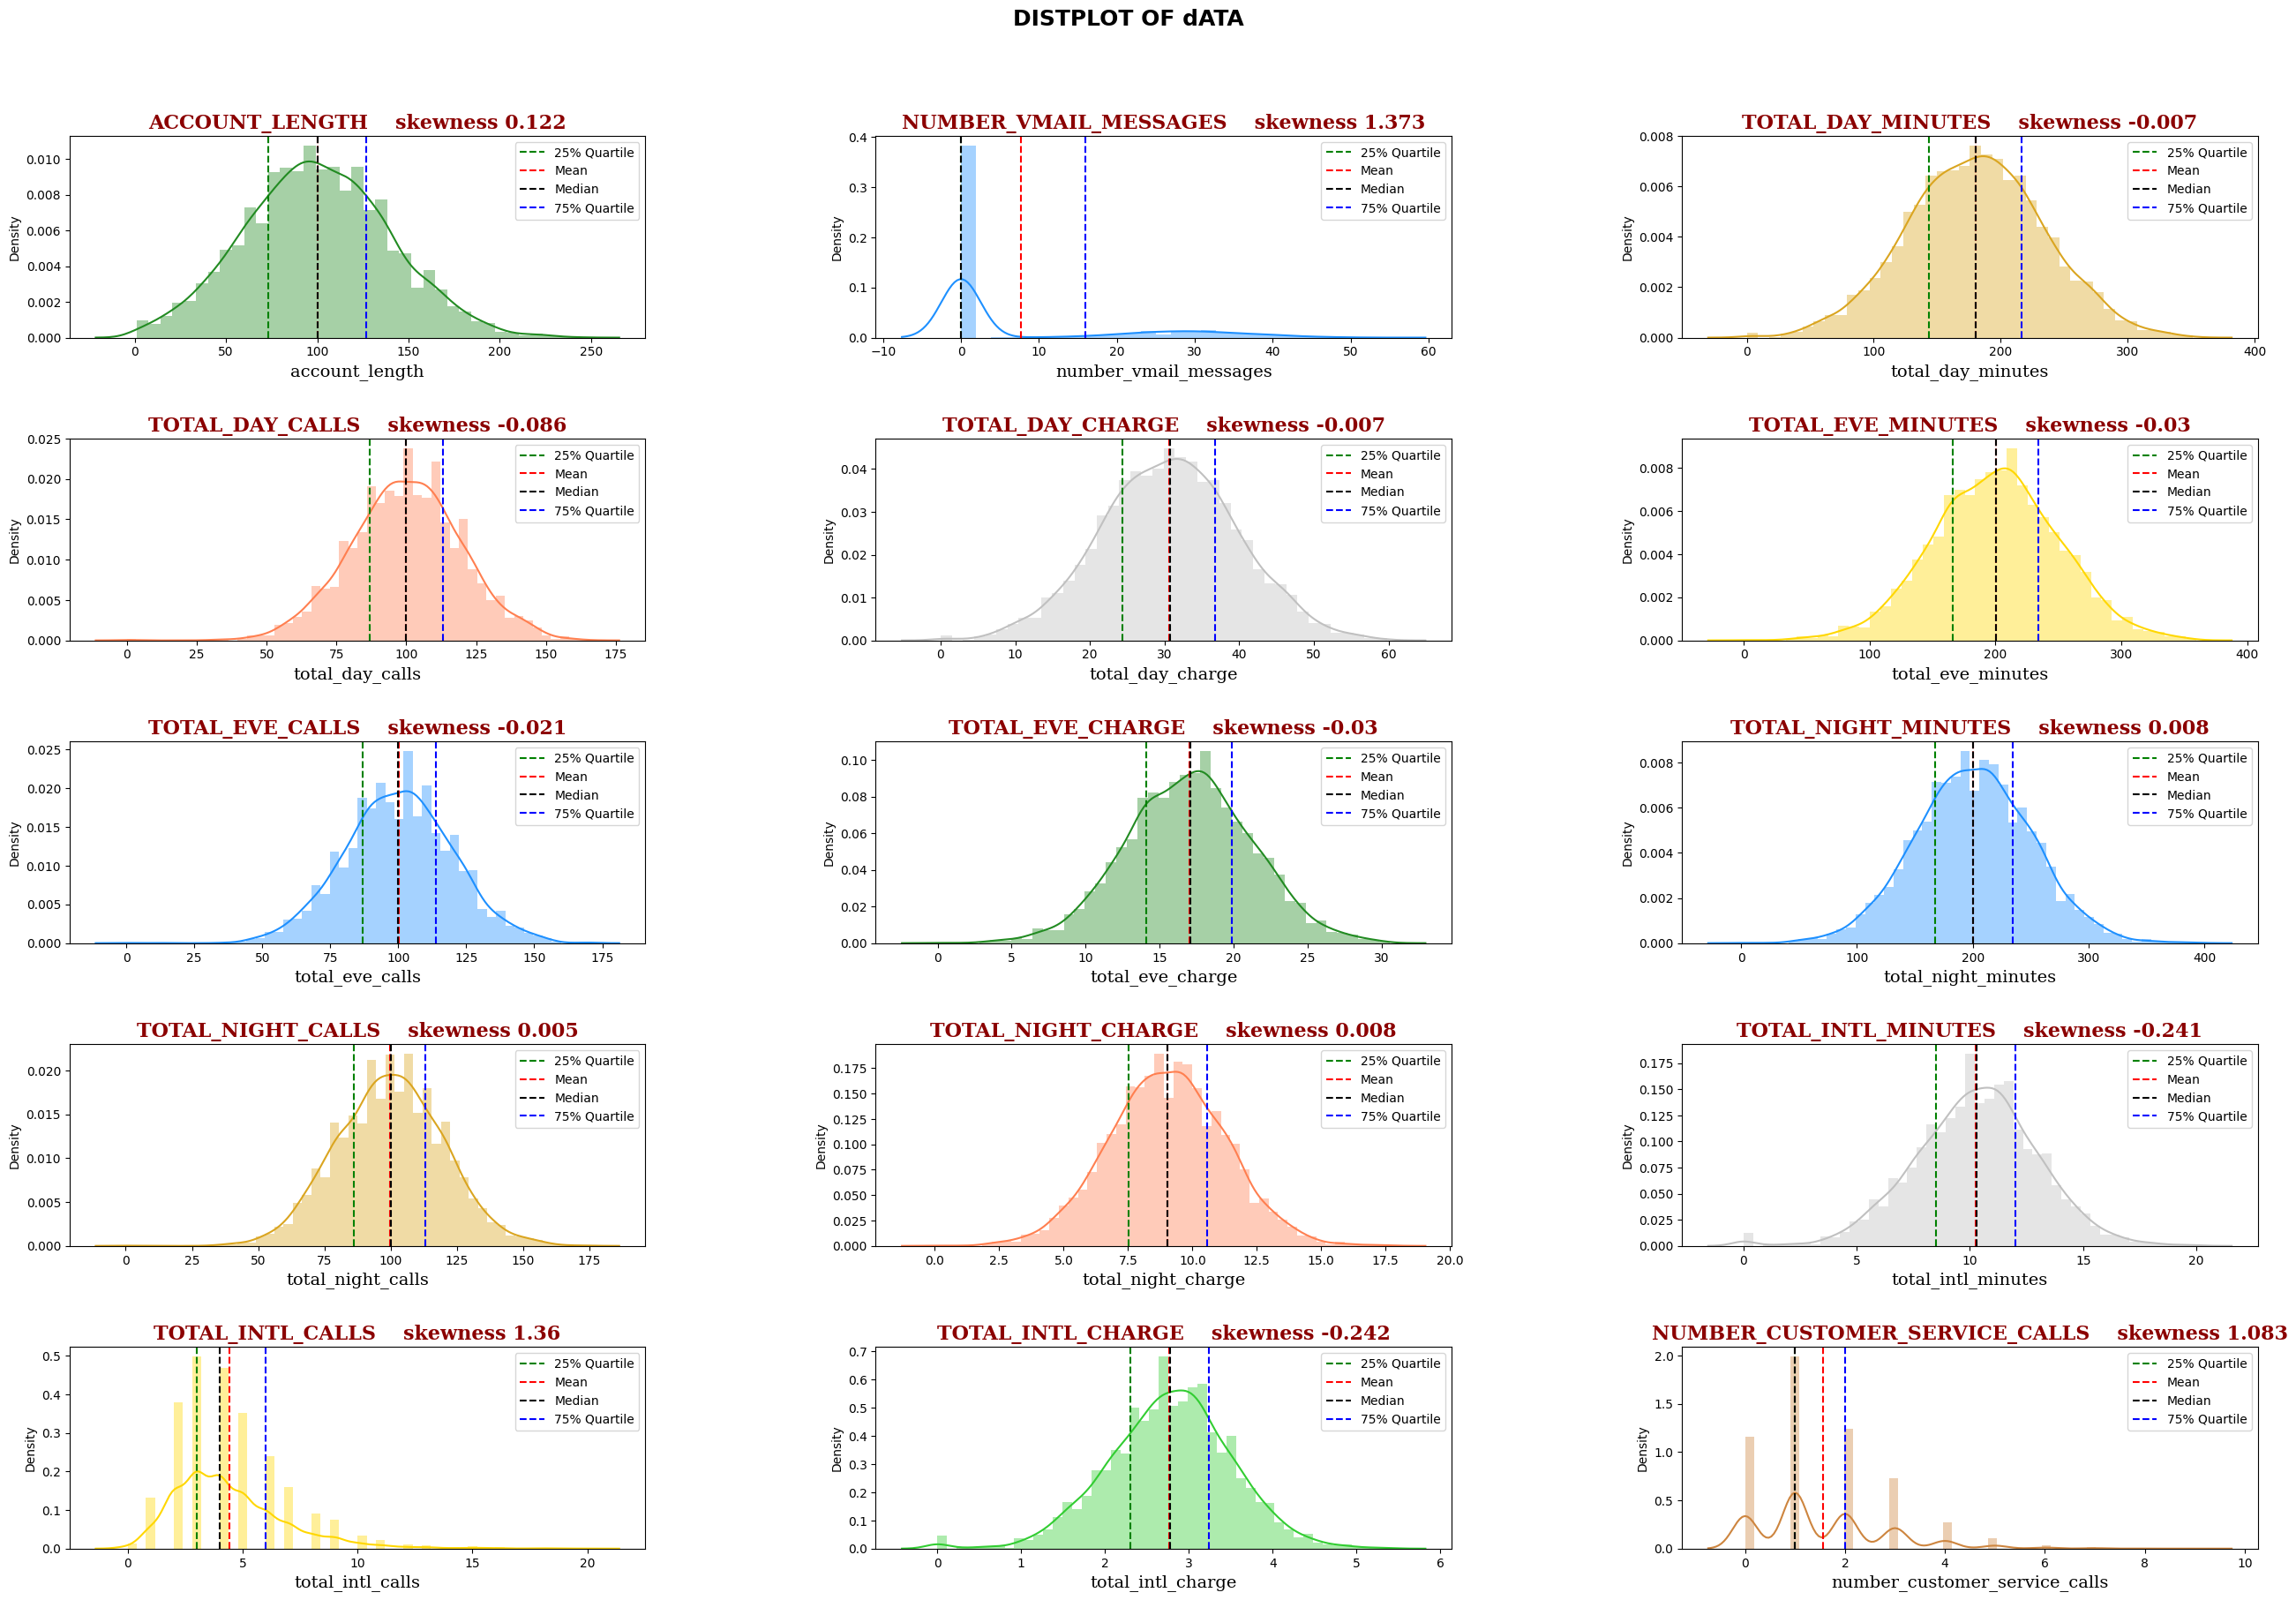

In [ ]:
#create figure with 3 x 3 grid of subplots
fig = plt.figure(figsize=[32,24])
fig.suptitle('DISTPLOT OF dATA', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(num_cols):
    ax = fig.add_subplot(6, 3, i+1)
    ax = sns.distplot(df[col],  color=colours[i])
    ax.axvline(df[col].quantile(q=0.25),color='green',linestyle='--',label='25% Quartile')
    ax.axvline(df[col].mean(),color='red',linestyle='--',label='Mean')
    ax.axvline(df[col].median(),color='black',linestyle='--',label='Median')
    ax.axvline(df[col].quantile(q=0.75),color='blue',linestyle='--',label='75% Quartile')
    # ax.text('skewness: {}' .format(str(round(df[col].skew(),3))), ha='right', va='center', size=11)
    ax.set_xlabel(f'{col}', fontdict=axlab_dict)
    ax.set_title(f'{col.upper()}    skewness {round(df[col].skew(),3)}', fontdict=axtitle_dict)
    ax.legend(fontsize=10)

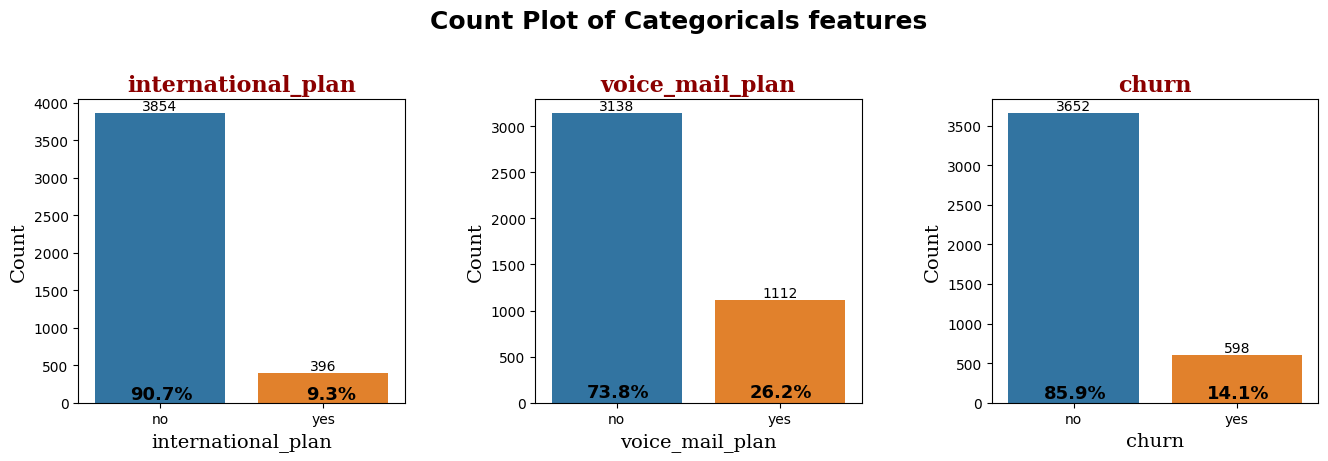

In [ ]:
fig = plt.figure(figsize=[16,15])
fig.suptitle('Count Plot of Categoricals features', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i , columns in enumerate(binary_cols):
    input = np.unique(df[columns] , return_counts = True)
    col= 'input'
    ax1 = fig.add_subplot(3, 3, i+1);
    ax1 = sns.barplot(x=list(eval(f'{col}[0]')), y=list(eval(f'{col}[1]')))
    #The below two lines of codes are used for percentage values.
    ax1.text(0.2, 120, '{}%' .format(str(round(eval(f'{col}[1][0]')/sum(eval(f'{col}[1]'))*100,1))), ha='right', va='center', size=13, fontdict={'weight': 'bold'})
    ax1.text(1.2, 120, '{}%' .format(str(round(eval(f'{col}[1][1]')/sum(eval(f'{col}[1]'))*100,1))), ha='right', va='center', size=13, fontdict={'weight': 'bold'})
    ax1.set_title(f'{columns}', fontdict=axtitle_dict)
    ax1.set_xlabel(f'{columns}', fontdict=axlab_dict)
    ax1.set_ylabel('Count', fontdict=axlab_dict)
    ax1.bar_label(ax1.containers[0])

In [ ]:
df['international_plan'].replace({'yes':1,'no':0},inplace=True)
df['voice_mail_plan'].replace({'yes':1,'no':0},inplace=True)
df['churn'].replace({'yes':1,'no':0},inplace=True)

In [ ]:
df.drop(columns=['state', 'area_code'],axis=1,inplace=True)

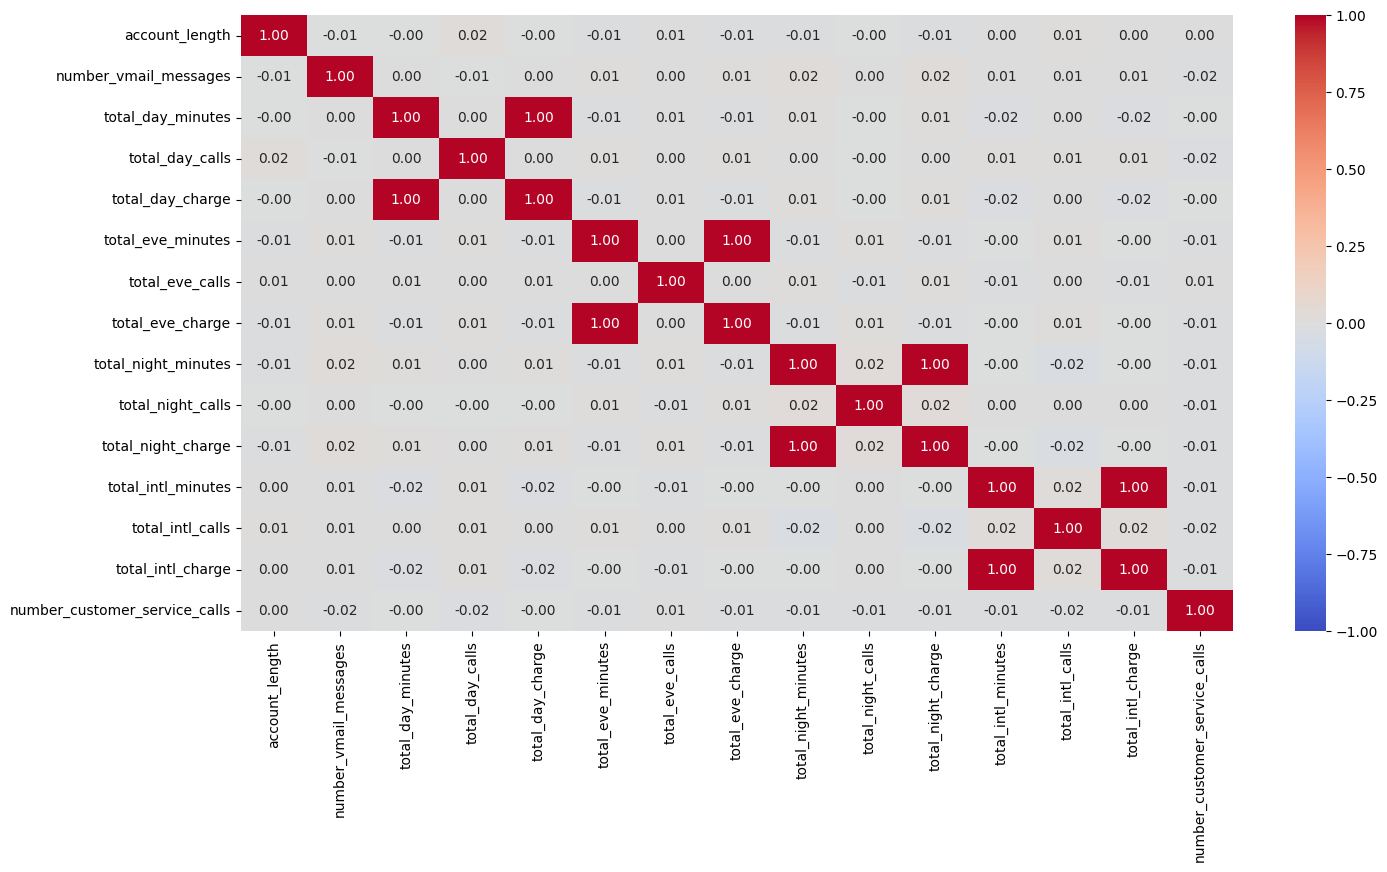

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap (df[num_cols].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm');

In [ ]:
num_cols =df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']


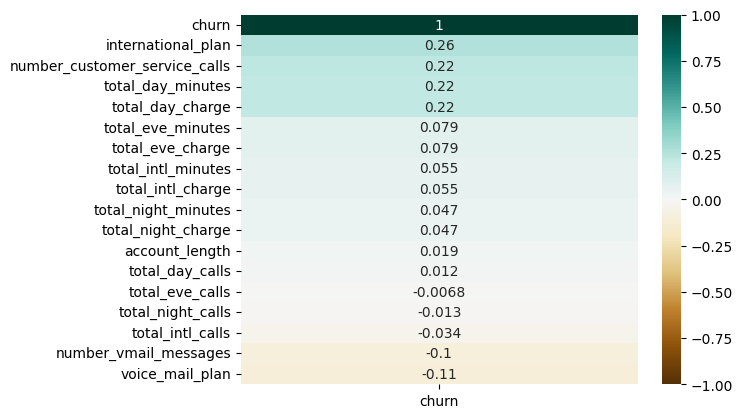

In [ ]:
heatmap = sns.heatmap(df[num_cols].corr()[['churn']].sort_values(by='churn', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [ ]:
df.head(1)

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0


генерация новых признаков

In [ ]:
total_calls = (
    df["total_day_calls"]
    + df["total_eve_calls"]
    + df["total_night_calls"]
    + df["total_intl_calls"]
)
df.insert(loc=len(df.columns), column="Total calls", value=total_calls)
# loc - номер столбца, после которого нужно вставить данный Series
# мы указали len(df.columns), чтобы вставить его в самом конце
df.head(1)

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,Total calls
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0,332


In [ ]:
df["Total charge"] = (
    df["total_day_charge"]
    + df["total_eve_charge"]
    + df["total_night_charge"]
    + df["total_intl_charge"]
)
df.head(1)

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,Total calls,Total charge
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0,332,59.24


In [ ]:
num_cols =df.select_dtypes(include=np.number).columns

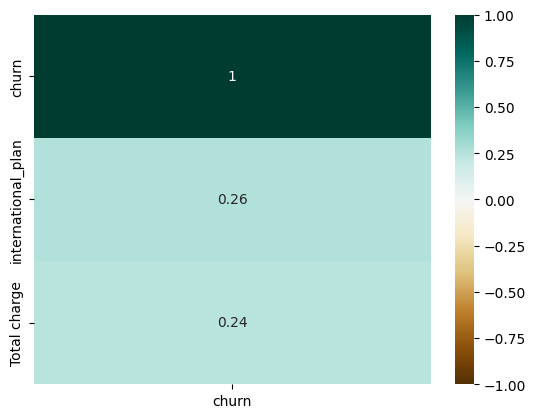

In [ ]:
heatmap = sns.heatmap(df[num_cols].corr()[['churn']].sort_values(by='churn', ascending=False)[:3], vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X = df.drop('churn', axis=1)
y = df["churn"]

In [ ]:
num_cols =X.select_dtypes(include=np.number).columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numerical_transformer = Pipeline([('scaler', StandardScaler())])

ct = ColumnTransformer([('num_transformer', numerical_transformer, num_cols)])
pipeline=Pipeline([('column_transformer', ct)])

In [ ]:
X_train = pipeline.fit_transform(X_train) # потом преобразуем  transform
X_test  = pipeline.transform(X_test) # для тестовых - просто transform

In [ ]:
from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import StratifiedKFold # при кросс-валидации разбиваем данные в пропорции целевой метки
from sklearn.neighbors import KNeighborsClassifier # Регрессия К-Ближайших соседей от scikit-learn

In [ ]:
from sklearn.metrics import accuracy_score # функция расчета доли правильных ответов от Scikit-learn
from sklearn.metrics import f1_score   # функция расчета f1-меры от Scikit-learn
from sklearn.metrics import classification_report # функция scikit-learn которая считает много метрик классификации

In [ ]:
# словарь гиперпараметров в виде
# обозначение гиперпараметров : в каких значениях проверяем
# обозначение должно "досимвольно" совпадать с тем что в документации
parameters = {'n_neighbors':np.arange(1,30,4),
              'weights':['uniform', 'distance']}

kNN_search = GridSearchCV(estimator = KNeighborsClassifier(), # оптимизируем наш модель
                          verbose = 3, # чтобы он всё подробно расписал. если не интересно - пишем 0
                          param_grid=parameters , # что оптимизируем - берем из словарика
                          cv=StratifiedKFold(n_splits=5) # указываем тип кросс-валидации
                          )

In [ ]:
kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.876 total time=   0.3s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.854 total time=   0.1s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.865 total time=   0.2s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.874 total time=   0.2s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.885 total time=   0.2s
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.876 total time=   0.2s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.854 total time=   0.3s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.865 total time=   0.2s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.874 total time=   0.1s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.885 total time=   0.0s
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.896 total time=   0.1s
[CV 2/5] END ....n_neighbors=5, weights=uniform;

In [ ]:
kNN_search.best_estimator_

KNeighborsClassifier(n_neighbors=9)

In [ ]:
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn
scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

scores = cross_validate(kNNbest, X_train, y_train,
                      scoring=scoring,
                      cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_best_kNN = pd.DataFrame(scores)
display(DF_cv_best_kNN)
print('\n')
print(DF_cv_best_kNN.mean()[2:])

Результаты Кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.002035,0.165192,0.900000,0.451613,0.903226,0.301075
1,0.001572,0.199642,0.900000,0.468750,0.882353,0.319149
2,0.001268,0.036449,0.897059,0.453125,0.852941,0.308511
3,0.001281,0.036875,0.898529,0.456693,0.878788,0.308511
4,0.001418,0.036249,0.913235,0.562963,0.926829,0.404255




test_ACC          0.901765
test_F1           0.478629
test_Precision    0.888827
test_Recall       0.328300
dtype: float64


In [ ]:
y_predict=kNNbest.predict(X_test)

print (classification_report(y_test, y_predict, target_names=['YES','NO']))

              precision    recall  f1-score   support

         YES       0.89      1.00      0.94       721
          NO       0.92      0.28      0.43       129

    accuracy                           0.89       850
   macro avg       0.90      0.64      0.68       850
weighted avg       0.89      0.89      0.86       850



In [ ]:
DF_class=pd.DataFrame(kNN_search.cv_results_)

DF = DF_class[['param_n_neighbors','param_weights',
               'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("seagreen", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
4,9,uniform,0.900294,0.003405,1
5,9,distance,0.900000,0.003085,2
6,13,uniform,0.898529,0.003085,3
7,13,distance,0.897941,0.002389,4
2,5,uniform,0.896471,0.007120,5
3,5,distance,0.896471,0.007120,5
9,17,distance,0.895588,0.002080,7
8,17,uniform,0.894118,0.002080,8
11,21,distance,0.893235,0.003554,9
10,21,uniform,0.891765,0.004706,10


добавляем новую функцию

#### - $w(d) = \frac{1}{d+a}$,
брать вес $\frac{1}{d}$ - неудачное решение, так как при $d = 0$ вес будет бесконечно большим


В `sklearn` такую ситуацию обходят путем присваивания веса 1 для такого объекта, а все остальные объекты будут иметь вес 0.

In [ ]:
def calc_weight_n_neigbours(dists):
    weights = np.zeros(dists.shape)

    for i in range(dists.shape[1]):
        weights[:, i] = 1/(i+1)

    return weights

In [ ]:
parameters = {'n_neighbors':np.arange(1,30,4),
              'weights':['uniform', 'distance',calc_weight_n_neigbours],
              'metric':["minkowski",'euclidean','manhattan','chebyshev']}
kNN_search = GridSearchCV(estimator = KNeighborsClassifier(), # оптимизируем наш модель
                          verbose = 3, # чтобы он всё подробно расписал. если не интересно - пишем 0
                          param_grid=parameters , # что оптимизируем - берем из словарика
                          cv=StratifiedKFold(n_splits=5) # указываем тип кросс-валидации
                          )

In [ ]:
kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.876 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.854 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.865 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.874 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.885 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.876 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.854 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.865 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.874 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.885 to

In [ ]:
kNN_search.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=17,
                     weights=<function calc_weight_n_neigbours at 0x7f083b676b90>)

In [ ]:
y_predict=kNNbest.predict(X_test)

print (classification_report(y_test, y_predict, target_names=['YES','NO']))

              precision    recall  f1-score   support

         YES       0.90      0.99      0.95       721
          NO       0.91      0.40      0.56       129

    accuracy                           0.90       850
   macro avg       0.91      0.70      0.75       850
weighted avg       0.90      0.90      0.89       850



image.png


улучшение результат -0.01


image.png


In [ ]:
DF_class=pd.DataFrame(kNN_search.cv_results_)

DF = DF_class[['param_n_neighbors','param_weights',
               'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("seagreen", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
62,17,,0.905000,0.005627,1
51,5,uniform,0.904412,0.008872,2
59,13,,0.904412,0.005261,2
52,5,distance,0.904412,0.008872,2
65,21,,0.903235,0.004687,5
68,25,,0.902647,0.004957,6
56,9,,0.902353,0.006281,7
54,9,uniform,0.901765,0.004499,8
71,29,,0.901765,0.005043,8
55,9,distance,0.901471,0.004054,10


uniform тоже хорошо предсказивает в целом (5 neighbors)

image.png

In [ ]:
df1 = pd.DataFrame({'Real': y_test, 'predicted': y_predict})

display(df1)

,Real,predicted
1024,0,0
2177,0,0
1444,0,0
3386,0,0
3203,0,0
...,...,...
1918,0,0
4180,1,1
2680,0,0
910,0,0


In [ ]:
err_ind=df1[df1.Real!=df1.predicted].index
err_ind

Int64Index([1138, 2528,  810,  151, 2649, 2562,  829,   96, 2346,  120, 2486,
            3424,  544, 3708,  602,    8, 3463, 3554, 2951, 4071, 2534, 1556,
            3734, 1818, 1192, 1557,  506,  862,   17,  205, 2456, 2179, 3542,
            3232, 2686, 1424, 3049, 2606, 1292, 1378,  330, 1293,  596, 1178,
            1611,  229, 2506, 2580,  408, 3437, 4061, 2387, 1800, 3837, 1675,
            2260, 3433, 2509, 2210, 2256, 1488, 4195, 3207, 2439, 1288, 3579,
            3166,   56, 1038, 2103, 1873, 2619, 2929, 4203, 2155, 2266,   76,
            3604, 2651,  387,  426, 1652],
           dtype='int64')

In [ ]:
df.iloc[err_ind][:4]

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,Total calls,Total charge
1138,98,0,0,0,0.0,0,0.00,159.6,130,13.57,167.1,88,7.52,6.8,1,1.84,4,1,219,22.93
2528,131,1,0,0,122.3,83,20.79,118.8,94,10.10,147.9,95,6.66,13.7,3,3.70,3,1,275,41.25
810,122,0,1,33,174.9,103,29.73,248.2,105,21.10,164.6,116,7.41,13.5,3,3.65,1,1,327,61.89
151,170,1,0,0,259.9,68,44.18,245.0,122,20.83,134.4,121,6.05,8.4,3,2.27,3,0,314,73.33


In [ ]:
df.loc[[1139,2529,811,152]]

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,Total calls,Total charge
1139,106,1,0,0,133.7,45,22.73,187.8,107,15.96,181.9,89,8.19,10.7,2,2.89,1,1,243,49.77
2529,105,0,0,0,259.3,96,44.08,175.2,97,14.89,222.4,36,10.01,12.0,5,3.24,3,0,234,72.22
811,93,0,0,0,190.2,68,32.33,262.2,64,22.29,130.0,92,5.85,8.8,4,2.38,0,0,228,62.85
152,73,0,0,0,214.3,145,36.43,268.5,135,22.82,241.2,92,10.85,10.8,13,2.92,1,0,385,73.02


работа с выбросами

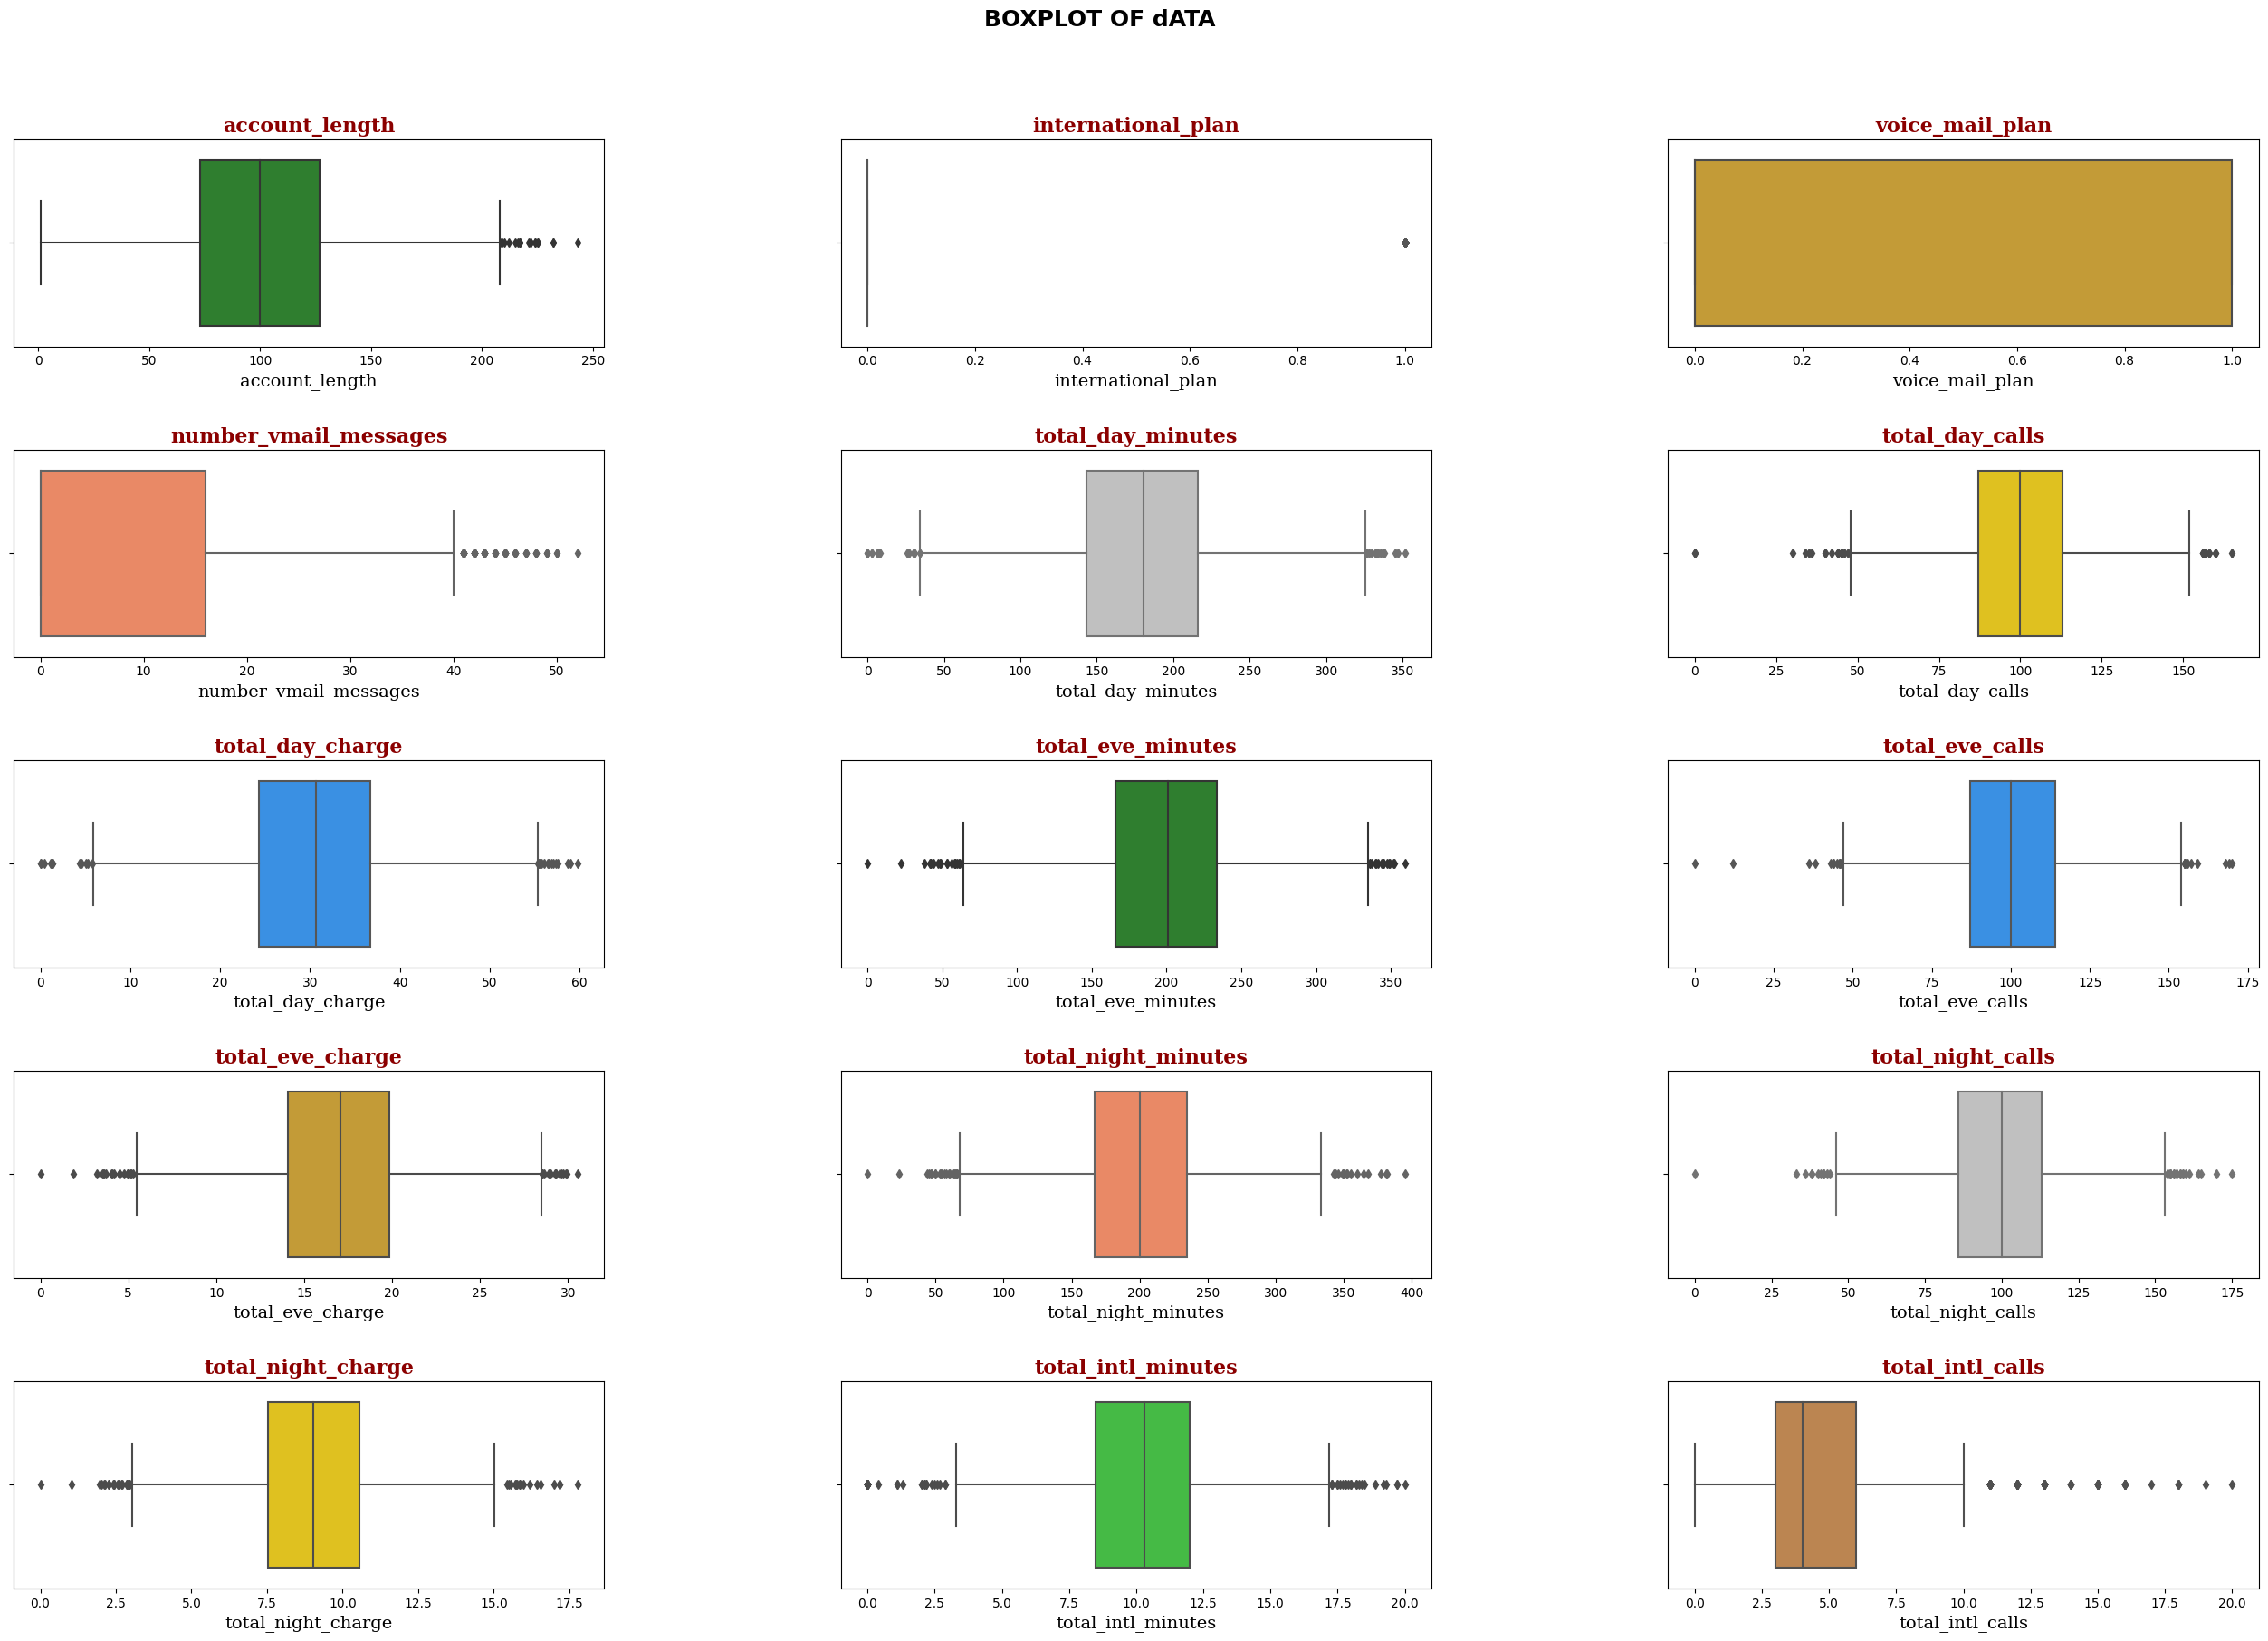

In [ ]:
#create figure with 3 x 3 grid of subplots
fig = plt.figure(figsize=[32,24])
fig.suptitle('BOXPLOT OF dATA', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(num_cols[:15]):
    ax1 = fig.add_subplot(6,3, i+1);
    ax1 = sns.boxplot(data = X, x=col,color=colours[i] );

    ax1.set_title(f'{col}', fontdict=axtitle_dict)
    ax1.set_xlabel(f'{col}', fontdict=axlab_dict)

In [ ]:
dict_1 = {}
for col in num_cols:
    percentile25 = X[col].quantile(0.25)
    percentile75 = X[col].quantile(0.75)
    IQR  = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * IQR
    lower_limit = percentile25 - 1.5 * IQR
    dict_1['upper_limit'+ '_' + col] = upper_limit
    dict_1['lower_limit'+ '_' + col] = lower_limit

выбираем  признаки без выбросов

In [ ]:
for col in num_cols:
    X[col] = np.where(
        X[col] > dict_1['upper_limit_' + col],
        dict_1['upper_limit_' + col],
        np.where(
            X[col] < dict_1['lower_limit_' + col],
            dict_1['lower_limit_' + col],
            X[col]
        )
    )

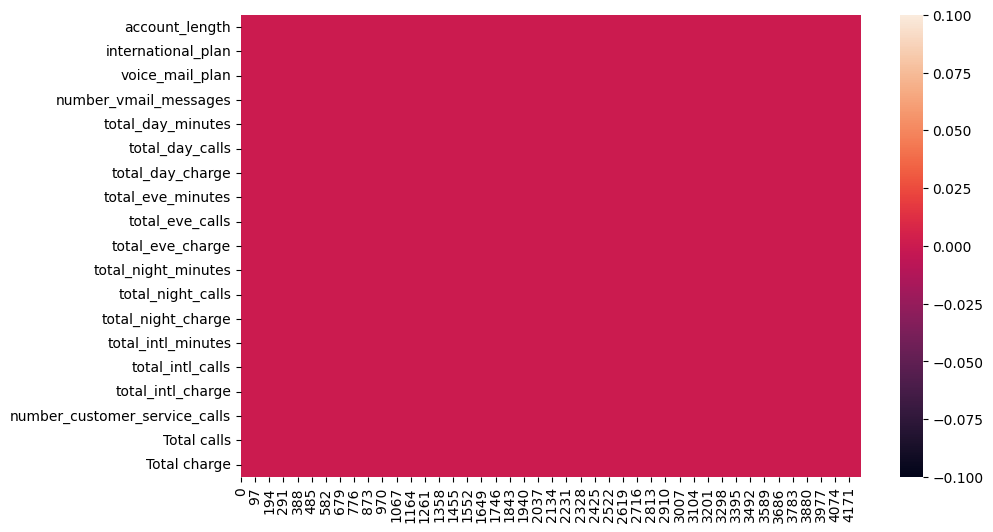

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(X[num_cols].isna().transpose());

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pipeline.fit_transform(X_train) # потом преобразуем  transform
X_test  = pipeline.transform(X_test) # для тестовых - просто transform

In [ ]:
kNNbest.fit(X_train, y_train);
y_predict=kNNbest.predict(X_test)

print (classification_report(y_test, y_predict, target_names=['YES','NO']))

              precision    recall  f1-score   support

         YES       0.89      0.99      0.94       721
          NO       0.91      0.33      0.48       129

    accuracy                           0.89       850
   macro avg       0.90      0.66      0.71       850
weighted avg       0.90      0.89      0.87       850



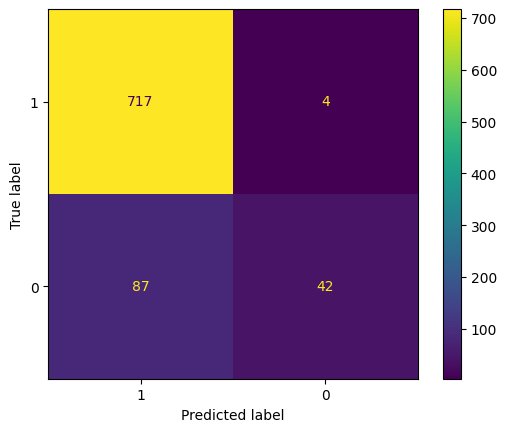

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_predict, labels=kNNbest.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kNNbest.classes_[::-1])
disp.plot()
plt.show()

In [ ]:
y_test[:10]

1024    0
2177    0
1444    0
3386    0
3203    0
721     0
3516    0
1113    0
1138    1
2528    1
Name: churn, dtype: int64

In [ ]:
kNNbest.predict_proba(X_test)[:,0][:10]

array([1.        , 1.        , 0.78666811, 0.97763573, 0.81309861,
       0.96365806, 1.        , 1.        , 0.76200691, 0.90793376])

In [ ]:
kNNbest.predict(X_test)[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
predict=kNNbest.predict(X_test)
accuracy_score(y_test,predict)

0.8929411764705882

In [ ]:
def custom_predict(X, threshold):
    probs = kNNbest.predict_proba(X_test)
    return (probs[:, 1] > threshold).astype(int)


new_preds = custom_predict(X=X_test, threshold=0.5)

как выше было

In [ ]:

accuracy_score(y_test,new_preds)

0.8929411764705882

теперь менаем для улучшения accuracy_score парог

In [ ]:
new_preds = custom_predict(X=X_test, threshold=0.4)

accuracy_score(y_test,new_preds)

0.8976470588235295

In [ ]:

print (classification_report(y_test, new_preds, target_names=['YES','NO']))

              precision    recall  f1-score   support

         YES       0.90      0.98      0.94       721
          NO       0.82      0.42      0.55       129

    accuracy                           0.90       850
   macro avg       0.86      0.70      0.75       850
weighted avg       0.89      0.90      0.88       850



как можно улучшить любой метрик класификации (важно цель)

#SVC

In [ ]:
from sklearn.svm import SVC # for Support Vector Classification model
parameters = [
	{"kernel":["linear"],
		"C": np.logspace(-2, 1, 20)},
	{"kernel":["poly"],
		"degree": [2, 3, 4],
		"C":  np.logspace(-2, 1, 20)},
	{"kernel":["rbf"],
		"gamma": ["auto", "scale"],
		"C":  np.logspace(-2, 1, 20)}]

svc_search = GridSearchCV(estimator = SVC(), # оптимизируем наш модель
                          verbose = 3, # чтобы он всё подробно расписал. если не интересно - пишем 0
                          param_grid=parameters , # что оптимизируем - берем из словарика
                          cv=StratifiedKFold(n_splits=5) )# указываем тип кросс-валидации

svc_search.fit(X_train, y_train)

svcbest=svc_search.best_estimator_

svcbest.fit(X_train, y_train);




Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.863 total time=   0.5s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.862 total time=   0.3s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.862 total time=   0.4s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.862 total time=   0.3s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.862 total time=   0.2s
[CV 1/5] END C=0.01438449888287663, kernel=linear;, score=0.863 total time=   0.2s
[CV 2/5] END C=0.01438449888287663, kernel=linear;, score=0.862 total time=   0.3s
[CV 3/5] END C=0.01438449888287663, kernel=linear;, score=0.862 total time=   0.3s
[CV 4/5] END C=0.01438449888287663, kernel=linear;, score=0.862 total time=   0.2s
[CV 5/5] END C=0.01438449888287663, kernel=linear;, score=0.862 total time=   0.2s
[CV 1/5] END C=0.0206913808111479, kernel=linear;, score=0.863 total time=   0.3s
[CV 2/5] END C=0.0206913808111479, 

In [ ]:
DF_class=pd.DataFrame(svc_search.cv_results_)
DF = DF_class[['params',
               'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("seagreen", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,params,mean_test_score,std_test_score,rank_test_score
111,"{'C': 2.3357214690901213, 'gamma': 'scale', 'kernel': 'rbf'}",0.909412,0.006417,1
110,"{'C': 2.3357214690901213, 'gamma': 'auto', 'kernel': 'rbf'}",0.909118,0.006127,2
114,"{'C': 4.832930238571752, 'gamma': 'auto', 'kernel': 'rbf'}",0.908824,0.007947,3
112,"{'C': 3.359818286283781, 'gamma': 'auto', 'kernel': 'rbf'}",0.908824,0.005955,3
107,"{'C': 1.1288378916846884, 'gamma': 'scale', 'kernel': 'rbf'}",0.908235,0.005549,5
115,"{'C': 4.832930238571752, 'gamma': 'scale', 'kernel': 'rbf'}",0.908235,0.008705,5
113,"{'C': 3.359818286283781, 'gamma': 'scale', 'kernel': 'rbf'}",0.908235,0.007759,5
109,"{'C': 1.623776739188721, 'gamma': 'scale', 'kernel': 'rbf'}",0.907941,0.004974,8
108,"{'C': 1.623776739188721, 'gamma': 'auto', 'kernel': 'rbf'}",0.907941,0.005310,8
106,"{'C': 1.1288378916846884, 'gamma': 'auto', 'kernel': 'rbf'}",0.907353,0.005343,10


In [ ]:
y_predict=svcbest.predict(X_test)

print (classification_report(y_test, y_predict, target_names=['YES','NO']))

              precision    recall  f1-score   support

         YES       0.91      0.99      0.95       721
          NO       0.91      0.47      0.62       129

    accuracy                           0.91       850
   macro avg       0.91      0.73      0.78       850
weighted avg       0.91      0.91      0.90       850



еще улучшение результат (0.01)

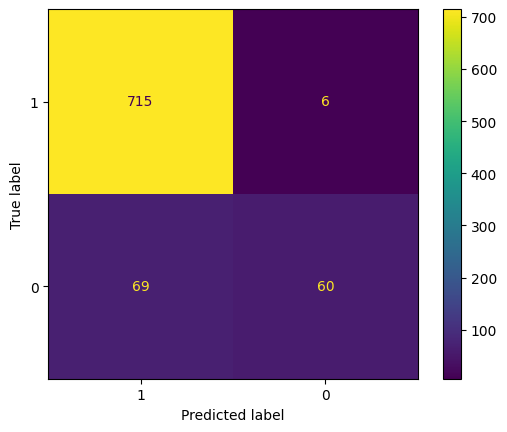

In [ ]:

cm = confusion_matrix(y_test, y_predict, labels=kNNbest.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kNNbest.classes_[::-1])
disp.plot()
plt.show()

In [ ]:
model = SVC(C=2.3357214690901213,kernel="rbf",probability=True)
model.fit(X_train, y_train)
results = model.predict_proba(X_test)[:,1]
results=(results>0.4).astype(int)

In [ ]:
accuracy_score(y_test,results)

0.9117647058823529

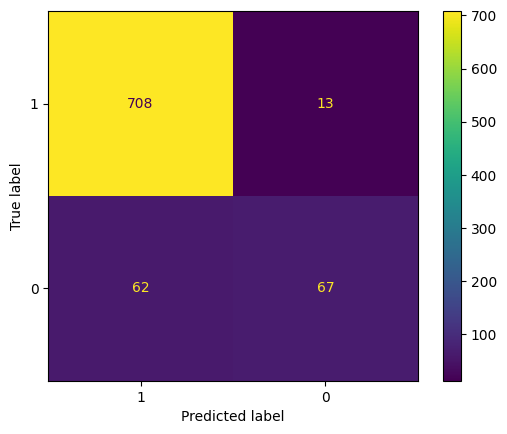

In [ ]:
cm = confusion_matrix(y_test, results, labels=kNNbest.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kNNbest.classes_[::-1])
disp.plot()
plt.show()

In [ ]:
print (classification_report(y_test, results, target_names=['YES','NO']))

              precision    recall  f1-score   support

         YES       0.92      0.98      0.95       721
          NO       0.84      0.52      0.64       129

    accuracy                           0.91       850
   macro avg       0.88      0.75      0.80       850
weighted avg       0.91      0.91      0.90       850



In [ ]:
results = model.predict_proba(X_test)[:,1]
results=(results>0.5).astype(int)
accuracy_score(y_test,results)

0.9141176470588235

In [ ]:
results = model.predict_proba(X_test)[:,1]
results=(results>0.3).astype(int)
accuracy_score(y_test,results)

0.8988235294117647